## Input Data

In [1]:
graph_path = "networks/flsaclr+1.graphml" #the path of the graph
output_path = "outputs/test.pdf" #path of your output with the extension.pdf

### Taxonomic keywords of interest

In [2]:
kw1="Rhizaria"
kw2=""

In [3]:
### Corresponding taxonomic levels
#1: Phylum
#2: Class
#3: Order
#4: Family
#5: Genus

In [4]:
level1 = 1
level2 = 5

## Computation

In [5]:
#%matplotlib notebook
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.backends.backend_pdf
import re
import ast
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance as ssd

In [6]:
def contract_network(G):
    cpt_contraction = 1
    while cpt_contraction != 0:
        dcontracted = dict()
        cpt_contraction = 0
        for n1,n2,d in G.edges(data=True):
            while n1 not in G.nodes():
                n1 = dcontracted[n1]
            while n2 not in G.nodes():
                n2 = dcontracted[n2]
            if n1==n2:
                continue
            d1 = G.nodes(data=True)[n1]
            d2 = G.nodes(data=True)[n2]
            if d1["dataset"] == d2["dataset"]:
                if d1["sequence"] == d2["sequence"]:
                    G = nx.contracted_nodes(G, n1, n2, self_loops=False)
                    dcontracted[n2] = n1
                    cpt_contraction += 1
                elif d1["taxonomy"] == d2["taxonomy"]:
                    G = nx.contracted_nodes(G, n1, n2, self_loops=False)
                    dcontracted[n2] = n1
                    cpt_contraction += 1
            elif d1["taxonomy"] == d2["taxonomy"]:
                G = nx.contracted_nodes(G, n1, n2, self_loops=False)
                cpt_contraction += 1
                dcontracted[n2] = n1
    return(G)

def match_interactions(G,kw1,kw2=None):
    matches = list()
    for n1 in G.nodes:
        tax1 = G.nodes[n1]["taxonomy"]
        if re.findall(kw1,tax1):
            if kw2 != None:
                connected = [ e[1] for e in G.edges(n1) ]
                for n2 in connected:
                    tax2 = G.nodes[n2]["taxonomy"]
                    if re.findall(kw2,tax2):
                        matches.append((n1,n2))

            else:
                matches.extend(list(G.edges(n1)))
    G = nx.edge_subgraph(G,matches)
    return(G)

def proportions_interactions(graphs,level1=1,level2=1,taxonomy="lineage",kw1=None,kw2=None,plot=True):
    if kw2=="":
        kw2=None
    df=pd.DataFrame()
    taxonomies=dict()
    for i in range(0,len(graphs)):
        G = graphs[i].copy()
        G = match_interactions(G,kw1,kw2)
        graphs[i] = G
        if G.size() == 0:
            print("No match")
        interactions = list([sorted([ast.literal_eval(G.nodes[n1]["lineage"])[level1],ast.literal_eval(G.nodes[n2]["lineage"])[level2]]) for n1,n2,d in G.edges(data=True)])
        groups = list(set(sum(interactions,[])))
        if 0 in groups:
            groups.pop(groups.index(0))
        for g in groups:
            taxonomies[g] = tax.loc[g,"taxonomy"].split(";")[-2]

    list_df = list()
    for i in range(0,len(graphs)):
        G = graphs[i]
        interactions = list([sorted([ast.literal_eval(G.nodes[n1]["lineage"])[level1],ast.literal_eval(G.nodes[n2]["lineage"])[level2]]) for n1,n2,d in G.edges(data=True)])
        if interactions == ():
            return
        if kw1 != None and kw2 == None:
            pivot = set([ast.literal_eval(d["lineage"])[level1] for n,d in G.nodes(data=True) if kw1 in d["taxonomy"]])
            if 0 in pivot:
                pivot.remove(0)
            df = pd.DataFrame(0,columns=[t.split(";")[-2] for t in tax.loc[pivot,"taxonomy"].values] ,index=taxonomies.values())
            for n1,n2 in interactions:
                if n1 in pivot and n2 != 0:
                    df.loc[taxonomies[n2],taxonomies[n1]]+=1
                elif n2 in pivot and n1 != 0:
                    df.loc[taxonomies[n1],taxonomies[n2]]+=1

        else:
            df = pd.DataFrame(0,columns=taxonomies.values() ,index=taxonomies.values())
            for n1,n2 in interactions:
                if n1 != 0 and n2 != 0:
                    df.loc[taxonomies[n1],taxonomies[n2]]+=1
                    df.loc[taxonomies[n2],taxonomies[n1]]+=1
        list_df.append(df)


    df=list_df[0].copy()
    if (kw1==None and kw2==None) or (kw1!=None and kw2!=None):
        try:
            Z = linkage(ssd.pdist(df), method="single")
        except ValueError:
            print("Empty matrix. Try another taxonomic levels")
            exit()
        labels = df.columns
        obj = dendrogram(Z,leaf_rotation=90,labels=labels,no_plot=True)
        names=obj["leaves"]
        names=[list(df.columns)[n] for n in names]
    else:
        names=taxonomies.values()

    for d in range(0,len(list_df)):
        if (kw1==None and kw2==None) or (kw1!=None and kw2!=None):
            list_df[d] = list_df[d].reindex(columns=names,index=names)
        else:
            list_df[d] = list_df[d].reindex(index=names)
        list_df[d] += 1 #avoid log 0 errors
        list_df[d] = np.log10(list_df[d])


    maxi = max([max(df.max()) for df in list_df])

    for d in range(0,len(list_df)):
        list_df[d]/=maxi

    for d in range(0,len(list_df)):
        if kw1 != None and kw2 == None:
            list_df[d] = list_df[d][(list_df[d].T != 0).any()]
            fig = plt.figure(figsize=(5,10))
            cmap = sns.color_palette("cubehelix_r", 100)
            sns.set(font_scale=1)
            sns.set_style("white")
            sns.heatmap(list_df[d],cbar_kws={"shrink": .5},cmap=cmap,vmin = 0, vmax = 1)#,linewidths=0.01,linecolor="grey")
            plt.tight_layout()
        else:
            mask = np.zeros_like(list_df[d], dtype=np.bool)
            mask[np.triu_indices_from(mask,k=1)] = True
            fig = plt.figure(figsize=(15,15))
            cmap = sns.color_palette("cubehelix_r", 100)
            sns.set(font_scale=1.3)
            sns.set_style("white")
            sns.heatmap(list_df[d],mask=mask,cbar_kws={"shrink": .5},cmap=cmap,vmin = 0, vmax = 1)#,linewidths=0.01,linecolor="grey")
            plt.tight_layout()
        pdf.savefig(fig)
    pdf.close()

In [7]:
tax = pd.read_csv("useful_tables/tax_slv_ssu_138.txt",
                          sep="\t",
                          header=None,
                          index_col=1,
                          names = ["taxonomy","rank","X","Y"])
tax = tax[["taxonomy","rank"]]
pdf = matplotlib.backends.backend_pdf.PdfPages(output_path)
graph = nx.read_graphml(graph_path)
#mgraph = contract_network(graph)

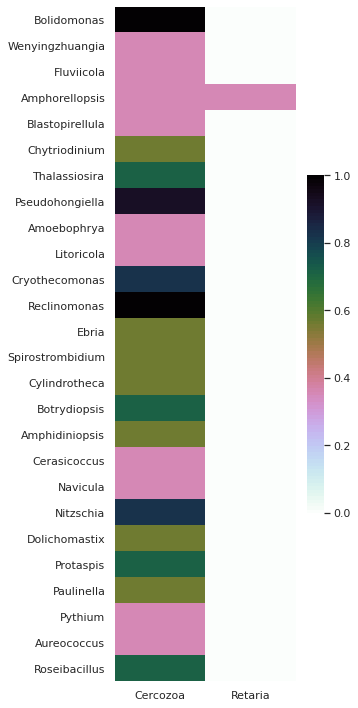

In [8]:
proportions_interactions([graph],level1=level1,level2=level2,taxonomy="lineage",kw1=kw1,kw2=kw2)